# BTC Investment Metrics Notebook

In [2]:
!pip install python-binance

  Using cached tzlocal-5.2-py3-none-any.whl.metadata (7.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.3 MB/s eta 0:00:0000:0100:01
Using cached tzlocal-5.2-py3-none-any.whl (17 kB)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
import matplotlib.dates as mdates
from dotenv import load_dotenv
import os

In [4]:
load_dotenv()

api_key = os.getenv('API_KEY')
api_secret = os.getenv('API_SECRET')
# Initialize the Binance client
client = Client(api_key, api_secret)

### BTC Price and Moving Average

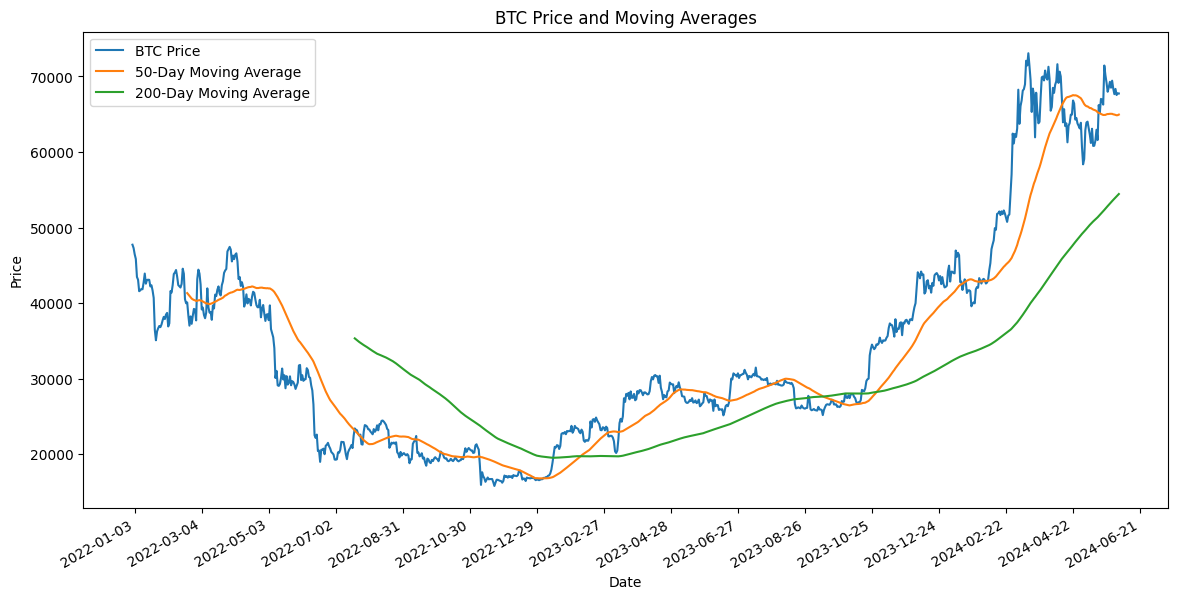

In [5]:


# Fetch historical data for BTC/USDT
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2022")

# Convert to DataFrame
data = pd.DataFrame(klines, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
data['Close'] = pd.to_numeric(data['Close'])

# Calculate Moving Averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Convert the 'Open time' from milliseconds to a readable date format
data['Date'] = pd.to_datetime(data['Open time'], unit='ms')

# Ensure your 'Close', 'MA50', and 'MA200' are all floats
data['Close'] = data['Close'].astype(float)
data['MA50'] = data['MA50'].astype(float)
data['MA200'] = data['MA200'].astype(float)

plt.figure(figsize=(14, 7))
# When plotting, specify the x-axis to use the 'Date' column
plt.plot(data['Date'], data['Close'], label='BTC Price')
plt.plot(data['Date'], data['MA50'], label='50-Day Moving Average')
plt.plot(data['Date'], data['MA200'], label='200-Day Moving Average')

# Use a DateFormatter to display dates on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))  # Adjust the interval as needed
plt.gcf().autofmt_xdate()  # Auto-format the dates to prevent overlap

plt.title('BTC Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### BTC Price and RSI over time

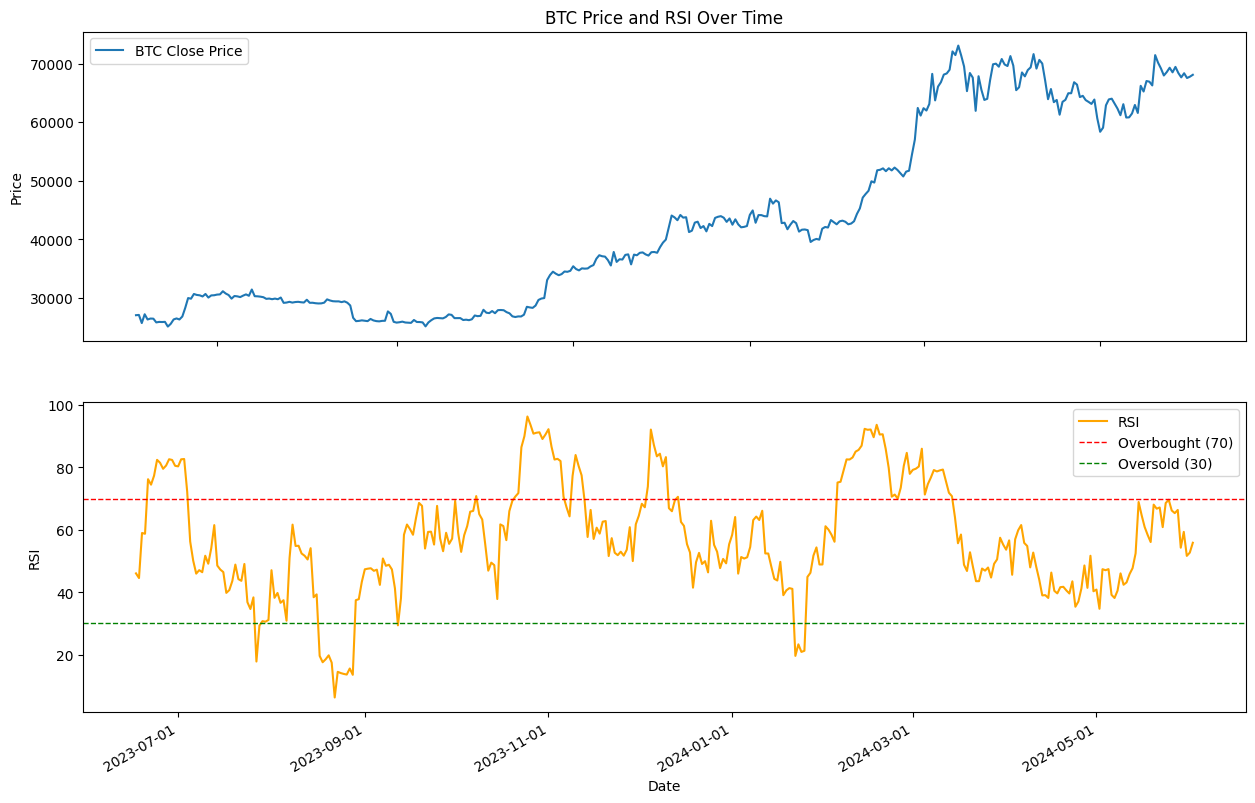

In [11]:

# Function to fetch data from Binance
def get_binance_data(symbol, interval, lookback):
    frame = pd.DataFrame(client.get_historical_klines(symbol, interval, lookback + ' ago UTC'))
    frame = frame.iloc[:, 0:6]
    frame.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame = frame.apply(pd.to_numeric, errors='coerce')
    frame['Timestamp'] = pd.to_datetime(frame['Timestamp'], unit='ms')
    return frame

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    up_days = delta.copy()
    down_days = delta.copy()
    
    up_days[up_days < 0] = 0
    down_days[down_days > 0] = 0
    
    # Calculate the Exponential Moving Average on up_days and down_days
    avg_up = up_days.rolling(window=window).mean()
    avg_down = down_days.abs().rolling(window=window).mean()
    
    rs = avg_up / avg_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Fetch data
data = get_binance_data('BTCUSDT', '1d', '1 year')

# Calculate RSI
data['RSI'] = calculate_rsi(data)

# Plotting
plt.figure(figsize=(15, 10))

# Subplot for Close price
plt.subplot(2, 1, 1)
plt.plot(data['Timestamp'], data['Close'], label='BTC Close Price')
plt.title('BTC Price and RSI Over Time')
plt.ylabel('Price')
plt.legend()

# Subplot for RSI
plt.subplot(2, 1, 2)
plt.plot(data['Timestamp'], data['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
plt.ylabel('RSI')
plt.xlabel('Date')
plt.legend()

# Format date on x-axis
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

### Calculate and Plot BTC Annualized Volatility

Annualized Volatility: 47.60%


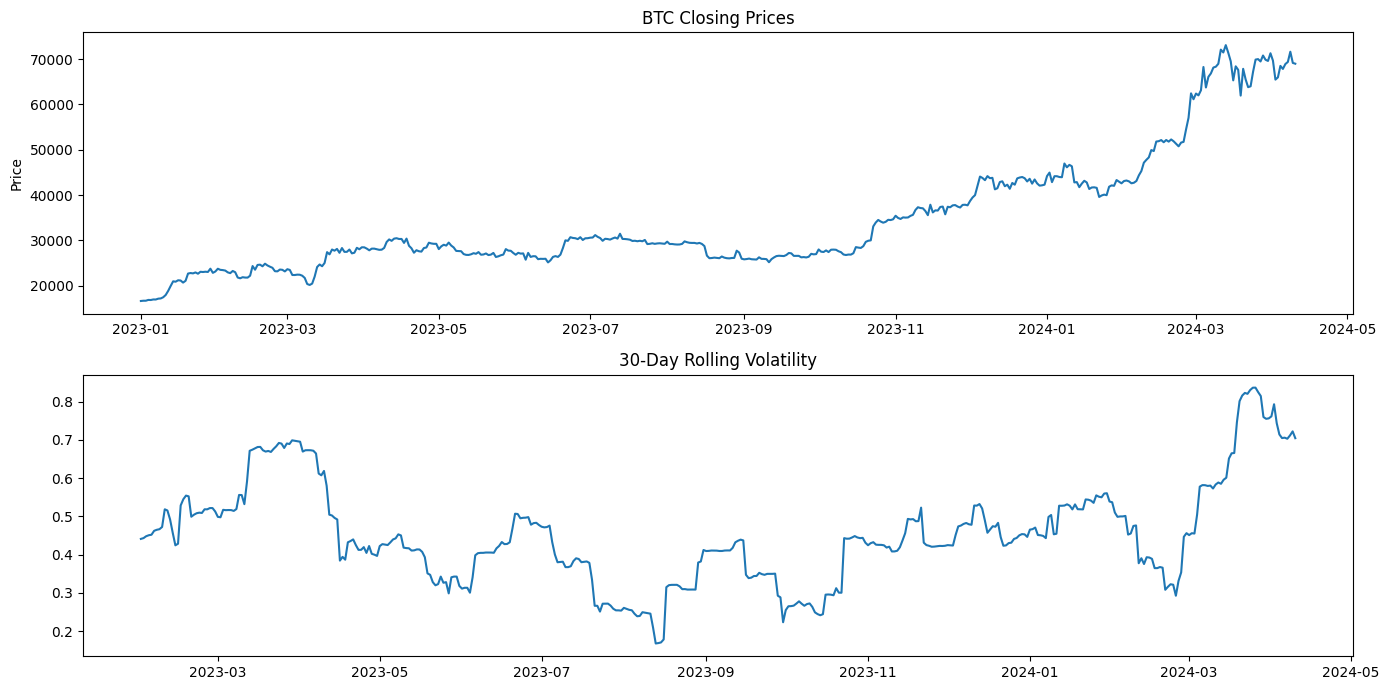

In [5]:


# Fetch historical candlestick data for BTCUSDT
candles = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2023")

# Convert to DataFrame
df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
df['close'] = pd.to_numeric(df['close'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Calculate log returns
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
volatility = df['log_return'].std() * np.sqrt(365)  # Annualized Volatility

print(f"Annualized Volatility: {volatility*100:.2f}%")

# Plot closing prices and volatility
plt.figure(figsize=(14, 7))
plt.subplot(2,1,1)
plt.plot(df['timestamp'], df['close'])
plt.title('BTC Closing Prices')
plt.ylabel('Price')

plt.subplot(2,1,2)
plt.plot(df['timestamp'], df['log_return'].rolling(window=30).std()*np.sqrt(365))
plt.title('30-Day Rolling Volatility')

plt.tight_layout()
plt.show()

#### Automated Asset Data Creation and Selection : Selecting assets based on liquidity and volatility factors

In [18]:
assets = ['BTC', 'ETH', 'SOL', 'ADA']
assets_data = []

for asset in assets:
    df = get_binance_data(f'{asset}USDT', '1d', '1 year')
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))  # Calculate log returns
    liquidity = df['Volume'].mean()  # Using average volume as a proxy for liquidity
    volatility = df['log_return'].std() * np.sqrt(365)  # Annualized Volatility
    assets_data.append({'asset': asset, 'liquidity': liquidity, 'volatility': volatility})

assets_data = pd.DataFrame(assets_data)

# Normalize factors (simple example, more sophisticated methods can be applied)
assets_data['liquidity_score'] = (assets_data['liquidity'] - assets_data['liquidity'].min()) / (assets_data['liquidity'].max() - assets_data['liquidity'].min())
assets_data['volatility_score'] = 1 - ((assets_data['volatility'] - assets_data['volatility'].min()) / (assets_data['volatility'].max() - assets_data['volatility'].min()))

# Composite score for selection
assets_data['score'] = assets_data['liquidity_score'] * 0.5 + assets_data['volatility_score'] * 0.5

# Select top N assets
selected_assets = assets_data.sort_values(by='score', ascending=False).head(2)
print(selected_assets)

  asset     liquidity  volatility  liquidity_score  volatility_score     score
3   ADA  1.316752e+08    0.726488              1.0          0.429058  0.714529
0   BTC  3.810259e+04    0.477493              0.0          1.000000  0.500000


#### Sharpe Ratio

Importance: It helps investors understand the return of an investment compared to its risk. A higher Sharpe Ratio indicates a more attractive risk-adjusted return.

The Sharpe Ratio is a measure of the risk-adjusted return of an investment. Generally, the higher the Sharpe Ratio, the better the risk-adjusted performance. Here are some benchmarks:

- Below 1.0: Subpar performance. Risk-adjusted returns are lower than expected.
- 1.0 - 1.99: Acceptable or good performance. The investment is offering better risk-adjusted returns than the risk-free rate.
- 2.0 - 2.99: Very good performance. The investment provides excellent risk-adjusted returns.
- 3.0 and above: Exceptional performance. The investment offers outstanding risk-adjusted returns.

In [25]:
portfolio_returns = pd.Series(np.random.normal(0.001, 0.02, 100))  # Simulated daily returns
risk_free_rate = 0.01  # Example risk-free rate

sharpe_ratio = (portfolio_returns.mean() - risk_free_rate) / portfolio_returns.std()

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: -0.40


#### RSI (Relative Strength Index)
The RSI is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of an asset. It ranges from 0 to 100, typically using thresholds of 70 (overbought) and 30 (oversold).

Importance: It can signal potential reversals in price direction. For instance, an RSI above 70 might suggest that an asset is overbought and could be due for a correction.

Here are some guidelines:
- RSI below 30: Indicates that an asset might be oversold and could be undervalued, signaling a potential buying opportunity.
- RSI above 70: Indicates that an asset might be overbought and could be overvalued, signaling a potential selling opportunity.
- RSI between 30 and 70: Considered a neutral range, suggesting that the asset is neither overbought nor oversold.

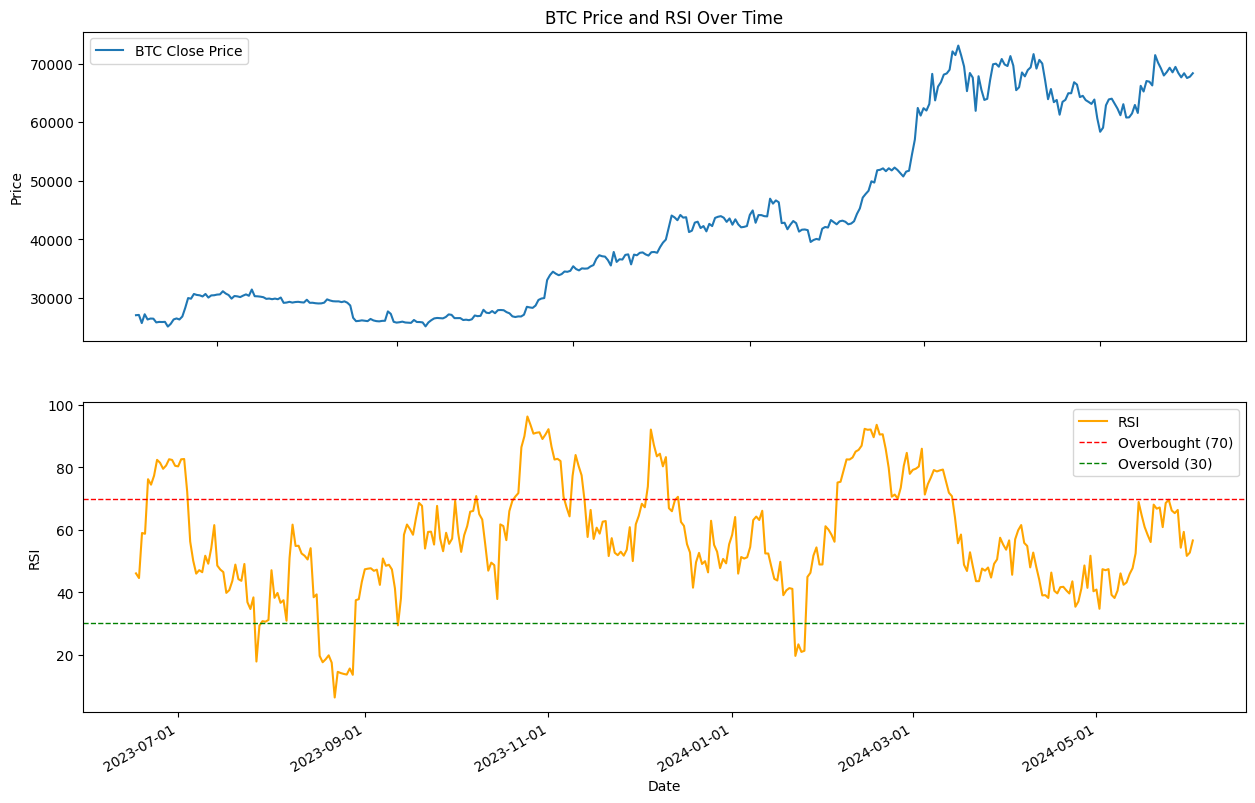

In [14]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    up_days = delta.copy()
    down_days = delta.copy()
    
    up_days[up_days < 0] = 0
    down_days[down_days > 0] = 0
    
    avg_up = up_days.rolling(window=window).mean()
    avg_down = down_days.abs().rolling(window=window).mean()
    
    rs = avg_up / avg_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Fetch data
data = get_binance_data('BTCUSDT', '1d', '1 year')

# Calculate RSI
data['RSI'] = calculate_rsi(data)

# Plotting
plt.figure(figsize=(15, 10))

# Subplot for Close price
plt.subplot(2, 1, 1)
plt.plot(data['Timestamp'], data['Close'], label='BTC Close Price')
plt.title('BTC Price and RSI Over Time')
plt.ylabel('Price')
plt.legend()

# Subplot for RSI
plt.subplot(2, 1, 2)
plt.plot(data['Timestamp'], data['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
plt.ylabel('RSI')
plt.xlabel('Date')
plt.legend()

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

#### Volatility
Volatility represents the degree of variation of an asset’s price over time. It is often measured by the standard deviation of returns.

Importance: Volatility is a key measure of risk. High volatility means the asset’s price can change dramatically in a short period, indicating higher risk and potentially higher returns. Low volatility indicates less risk but also typically lower returns.

Annualized Volatility: 48.05%


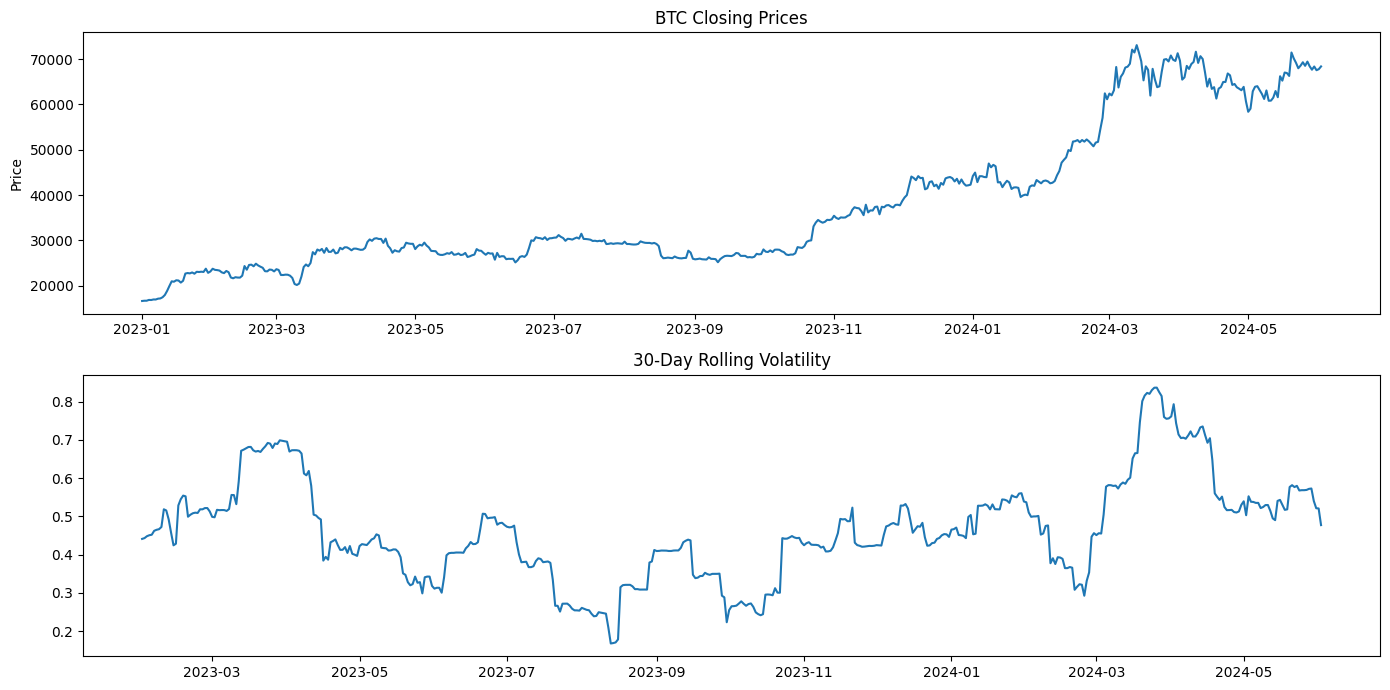

In [15]:
candles = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2023")

# Convert to DataFrame
df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
df['close'] = pd.to_numeric(df['close'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Calculate log returns
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
volatility = df['log_return'].std() * np.sqrt(365)  # Annualized Volatility

print(f"Annualized Volatility: {volatility*100:.2f}%")

# Plot closing prices and volatility
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['close'])
plt.title('BTC Closing Prices')
plt.ylabel('Price')

plt.subplot(2, 1, 2)
plt.plot(df['timestamp'], df['log_return'].rolling(window=30).std() * np.sqrt(365))
plt.title('30-Day Rolling Volatility')

plt.tight_layout()
plt.show()


#### Asset Allocation: 
Determine the percentage of your portfolio to allocate to different asset classes based on your risk tolerance, investment horizon, and financial goals. This might include a mix of cryptocurrencies, stocks, bonds, and other investments.


In [22]:
# Asset Allocation: Determine the percentage of your portfolio to allocate to different asset classes based on your risk tolerance, investment horizon, and financial goals. This might include a mix of cryptocurrencies, stocks, bonds, and other investments.


def asset_allocation(portfolio, risk_tolerance):
    # Example allocation based on risk tolerance
    if risk_tolerance == 'high':
        return {'stocks': 0.7, 'bonds': 0.1, 'crypto': 0.2}
    elif risk_tolerance == 'medium':
        return {'stocks': 0.5, 'bonds': 0.3, 'crypto': 0.2}
    else:
        return {'stocks': 0.3, 'bonds': 0.6, 'crypto': 0.1}

# Example portfolio
portfolio = 100000  # Total investment amount
risk_tolerance = 'medium'
allocation = asset_allocation(portfolio, risk_tolerance)

print(f"Asset Allocation for {risk_tolerance} risk tolerance: {allocation}")

Asset Allocation for medium risk tolerance: {'stocks': 0.5, 'bonds': 0.3, 'crypto': 0.2}


#### Dollar-Cost Averaging (DCA)

Invest a fixed amount in a particular asset at regular intervals, regardless of the asset's price. This strategy can help reduce the impact of volatility and lower the average cost of investments over time.

         Date  BTC Bought     Price  Investment  Total BTC  Total Investment  \
0  2021-06-03    0.025480  39246.79      1000.0   0.025480            1000.0   
1  2021-07-03    0.028844  34669.13      1000.0   0.054324            2000.0   
2  2021-08-02    0.025544  39147.82      1000.0   0.079868            3000.0   
3  2021-09-01    0.020487  48810.52      1000.0   0.100355            4000.0   
4  2021-10-01    0.020772  48141.61      1000.0   0.121128            5000.0   
5  2021-10-31    0.016313  61299.80      1000.0   0.137441            6000.0   
6  2021-11-30    0.017559  56950.56      1000.0   0.155000            7000.0   
7  2021-12-30    0.021222  47120.87      1000.0   0.176222            8000.0   
8  2022-01-29    0.026201  38166.84      1000.0   0.202423            9000.0   
9  2022-02-28    0.023170  43160.00      1000.0   0.225592           10000.0   
10 2022-03-30    0.021246  47067.99      1000.0   0.246838           11000.0   
11 2022-04-29    0.025909  38596.11     

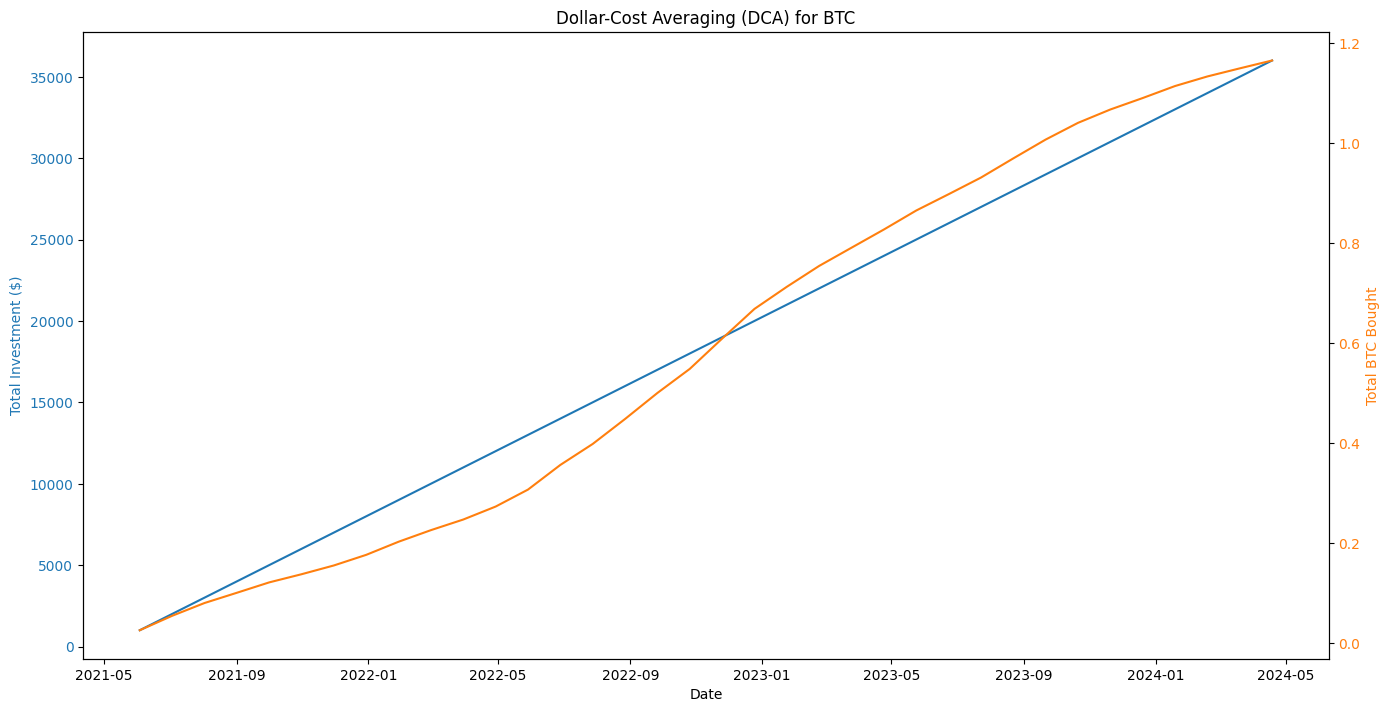

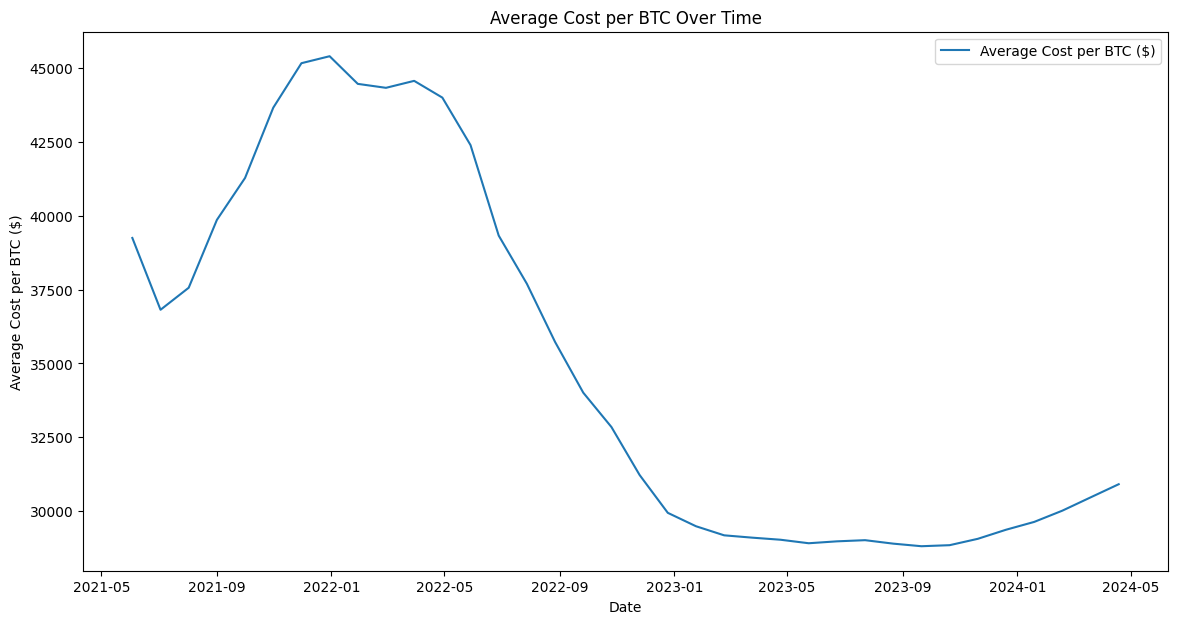

In [35]:
# Dollar-Cost Averaging (DCA): Invest a fixed amount in a particular asset at regular intervals, regardless of the asset's price.
def dollar_cost_averaging(data, total_investment, periods_per_year):
    investment_per_period = total_investment / periods_per_year
    interval = len(data) // periods_per_year
    investment_data = []
    for i in range(0, len(data), interval):
        if len(investment_data) >= periods_per_year:
            break
        price = data['Close'].iloc[i]
        btc_bought = investment_per_period / price
        investment_data.append({'Date': data['Timestamp'].iloc[i], 'BTC Bought': btc_bought, 'Price': price, 'Investment': investment_per_period})
    investment_df = pd.DataFrame(investment_data)
    investment_df['Total BTC'] = investment_df['BTC Bought'].cumsum()
    investment_df['Total Investment'] = investment_df['Investment'].cumsum()
    investment_df['Average Cost per BTC'] = investment_df['Total Investment'] / investment_df['Total BTC']
    return investment_df

# Fetch historical data for BTC/USDT for the past 3 years
data = get_binance_data('BTCUSDT', '1d', '3 year')

# Set the total investment and the number of periods (e.g., monthly investments over 3 years)
total_investment = 36000  # Total investment amount
periods_per_year = 12  # Monthly investments
total_periods = 3 * periods_per_year  # Total periods over 3 years

# Calculate DCA
dca_df = dollar_cost_averaging(data, total_investment, total_periods)

# Print the DCA results
print(dca_df)

# Plot the DCA results with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Investment ($)', color='tab:blue')
ax1.plot(dca_df['Date'], dca_df['Total Investment'], label='Total Investment ($)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
ax2.set_ylabel('Total BTC Bought', color='tab:orange')
ax2.plot(dca_df['Date'], dca_df['Total BTC'], label='Total BTC Bought', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()  # to prevent the labels from overlapping
plt.title('Dollar-Cost Averaging (DCA) for BTC')
plt.show()

# Plot the average cost per BTC
plt.figure(figsize=(14, 7))
plt.plot(dca_df['Date'], dca_df['Average Cost per BTC'], label='Average Cost per BTC ($)')
plt.title('Average Cost per BTC Over Time')
plt.xlabel('Date')
plt.ylabel('Average Cost per BTC ($)')
plt.legend()
plt.show()

#### Risk Management: 
Implement stop-loss orders and take-profit levels to manage risk effectively. Knowing when to exit an investment is as crucial as knowing when to enter.

In [36]:
def implement_stop_loss(current_price, stop_loss_level):
    return current_price * (1 - stop_loss_level / 100)

def implement_take_profit(current_price, take_profit_level):
    return current_price * (1 + take_profit_level / 100)

current_price = 50000  # Current price of the asset
stop_loss_level = 10  # Stop loss at 10%
take_profit_level = 20  # Take profit at 20%

stop_loss_price = implement_stop_loss(current_price, stop_loss_level)
take_profit_price = implement_take_profit(current_price, take_profit_level)

print(f"Stop Loss Price: {stop_loss_price}")
print(f"Take Profit Price: {take_profit_price}")


Stop Loss Price: 45000.0
Take Profit Price: 60000.0


#### Rebalancing

Regularly adjust your portfolio to maintain your desired asset allocation. This might involve selling assets that have increased in value and buying those that have decreased to maintain your risk level and investment strategy.

In [24]:

def rebalance_portfolio(portfolio, target_allocation):
    total_value = sum(portfolio.values())
    for asset, value in portfolio.items():
        target_value = total_value * target_allocation[asset]
        if value > target_value:
            sell_amount = value - target_value
            print(f"Sell {sell_amount} of {asset}")
        elif value < target_value:
            buy_amount = target_value - value
            print(f"Buy {buy_amount} of {asset}")

# Example portfolio and target allocation
portfolio = {'stocks': 60000, 'bonds': 30000, 'crypto': 10000}
target_allocation = {'stocks': 0.5, 'bonds': 0.3, 'crypto': 0.2}

rebalance_portfolio(portfolio, target_allocation)

Sell 10000.0 of stocks
Buy 10000.0 of crypto
